# Imports

In [2]:
# stdlib
import re
import copy
import random
import itertools
import statistics
import multiprocessing

# data wrangling
import numpy as np
import pandas as pd
import statsmodels.api as sm

from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# custom
from hotspot_classes import Hotspot
import hotspot_utils
import mlr_utils

# Set the number of processors to use for parallel processing
n_processors = max([1,multiprocessing.cpu_count()-2])

# Read in the insults list
with open('insults.txt', 'r') as f:
    insults = f.read().splitlines()

# Reading data - Works for single or double file layouts

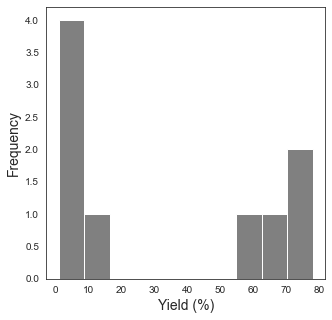

,Yield (%),nbo_lp_P_e_boltz,pyr_P_boltz,vbur_vbur_min
ID,,,,
1,1,-0.300539,0.925709,56.456887
3,1,-0.295813,0.931197,56.874203
4,1,-0.294567,0.929776,55.427717
64,3,-0.295658,0.885927,59.639575
89,77,-0.280946,0.818824,78.888404
102,14,-0.292564,0.913858,62.697800
103,63,-0.281184,0.814801,74.987180
347,78,-0.269589,0.816870,74.409841
369,62,-0.270709,0.813021,73.230060


In [7]:
# This cell assumes that your spreadsheets are in .xlsx format and that there are no columns after the parameters
# or rows after the last reaction. Extra rows and columns before the data are fine and can be skipped with the
# vs_parameters_header_rows and vs_parameters_start_col variables.
# Check cell outputs to make sure everything looks good

parameters_file = "phosphine_train-val" # Excel file to pull parameters from
parameters_sheet = "training" # Sheet in the Excel file to pull parameters from
parameters_start_col = 2 # 0-indexed column number where the parameters start
parameters_y_label_col = 0  # 0-indexed column number where the ligand labels are
parameters_header_rows = 0 # Number of rows to skip when reading the parameters

response_file = "phosphine_train-val" # Excel file to pull responses from
response_sheet = "training" # Sheet in the Excel file to pull responses from
response_col = 1 # 0-indexed column number for the responses
response_y_label_col = 0  # 0-indexed column number where the ligand labels are
response_header_rows = 0 # Number of rows to skip when reading the responses

RESPONSE_LABEL = "Yield (%)" # Name of your response variable

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Actually start reading stuff into dataframes
parameters_df = pd.read_excel("./InputData/" + parameters_file + ".xlsx",
                              parameters_sheet,
                              header = parameters_header_rows,
                              index_col = parameters_y_label_col,
                              )
response_df = pd.read_excel("./InputData/" + response_file + ".xlsx",
                            response_sheet,
                            header = response_header_rows,
                            index_col = response_y_label_col,
                            usecols = list(range(0, response_col + 1))
                            )


# Drop any columns before parameters_start_col that are not the index column
parameters_columns_to_keep = [col for col in range(0, len(parameters_df.columns)) if col >= parameters_start_col-1]
parameters_df = parameters_df.iloc[:,parameters_columns_to_keep]

# Combine the two dataframes into the master dataframe
response_df.drop(response_df.columns[0:response_col-1], axis = 'columns', inplace = True)
data_df = response_df.merge(parameters_df, left_index = True, right_index = True)
data_df.rename(columns = {data_df.columns.values[0]: RESPONSE_LABEL}, inplace = True) # Converts the output column name from whatever it is on the spreadsheet
data_df.dropna(inplace = True) # Remove any rows with blanks

# This converts all the data to numeric values since it was reading them in as non-numeric objects for some reason
for column in data_df.columns:
    data_df[column] = pd.to_numeric(data_df[column], errors='coerce')

# Get a list of all the features
all_features = list(data_df.columns)
all_features.remove(RESPONSE_LABEL)

# Check for duplicate reaction labels or column names
error = False
if len(list(data_df.index)) != len(list(set(data_df.index))):
    print('THERE ARE DUPLICATE REACTION LABELS IN THE DATA. PLEASE CORRECT THIS IN YOUR SPREADSHEET.')
    error = True
if len(list(data_df.columns)) != len(list(set(data_df.columns))):
    print('THERE ARE DUPLICATE COLUMN NAMES IN THE DATA. PLEASE CORRECT THIS IN YOUR SPREADSHEET.')
    error = True

if not error:
    # Print out the data distribution of the response variable
    plt.figure(figsize=(5, 5))
    plt.hist(data_df[RESPONSE_LABEL], color='grey')
    plt.xlabel(RESPONSE_LABEL, fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.show()

    # Display the dataframe
    display(data_df)

# Basic visualization

## Histograms and univariate correlations

['nbo_lp_P_e_boltz', 'pyr_P_boltz', 'vbur_vbur_min']
nbo_lp_P_e_boltz


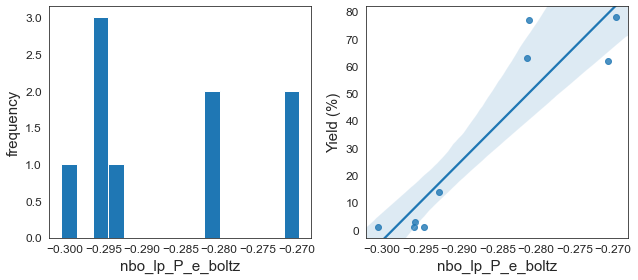

R^2 = 0.85; p-value = 3.62E-04

-------------------------------------------------------------------------------

pyr_P_boltz


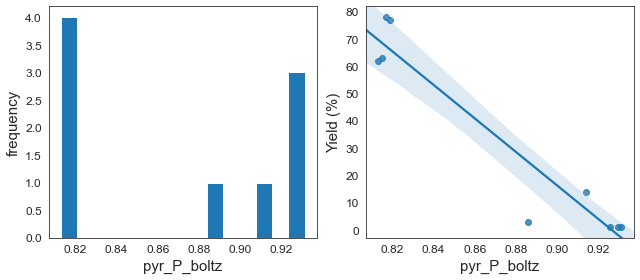

R^2 = 0.91; p-value = 5.70E-05

-------------------------------------------------------------------------------

vbur_vbur_min


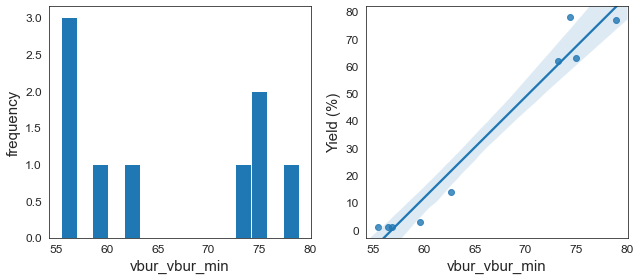

R^2 = 0.96; p-value = 2.77E-06

-------------------------------------------------------------------------------

At least one result!


In [8]:
# {features} should be a list of feature names or column numbers you want to get the distribution and correlation for
features = all_features # Cycles through all features
# features = list(range(4,16)) + [27, 32] # Cycles through a specific set of features by column number
# features = ['vbur_vbur_min', 'vmin_vmin_boltz'] # Cycles through a specific set of features by name

r2_cutoff = 0.3 # R^2 cutoff for correlation below which the feature will be skipped

# This feels like a relic of a bygone era, but here it is. 'matplotlib' refers to what was once the 'OG' cell.
visualization_type = 'seaborn' # 'matplotlib' or 'seaborn'

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Convert all features to column names
features = mlr_utils.process_features(features, data_df)
print(features)

anything = False
for feature in features:
    print(feature)

    # If the feature has no variance it would break the math later on, so we skip it
    if data_df[feature].std() == 0:
        print("No variance in feature. Skipping.")
        continue

    # Get stats and line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[feature], data_df[RESPONSE_LABEL])
    fit_line = intercept+slope*data_df[feature]

    # Skip the rest if R^2 is below the cutoff
    if r_value**2 < r2_cutoff:
        print("R^2 below cutoff. Skipping.")
        continue

    plt.figure(figsize=(9, 4))
    
    # Plot feature distribution
    plt.subplot(1,2,1)
    plt.hist(data_df[feature], bins=15)
    plt.ylabel("frequency",fontsize=15)
    plt.xlabel(f'{feature}',fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    # Plot univariate correlation
    plt.subplot(1,2,2)

    if visualization_type == 'matplotlib':
        plt.scatter(data_df[feature], data_df[RESPONSE_LABEL],color="black",marker="s",alpha=0.5)    
        plt.plot(data_df[feature],fit_line,color="black")
    elif visualization_type == 'seaborn':
        sns.set_style("white")
        sns.regplot(x=data_df[feature],y=data_df[RESPONSE_LABEL],ci=95,truncate=False)
        x_max=np.max(data_df[feature])
        x_min=np.min(data_df[feature])
        y_max=np.max(data_df[RESPONSE_LABEL])
        y_min=np.min(data_df[RESPONSE_LABEL])
        delta_x = 0.05 * (x_max-x_min)
        delta_y = 0.05 * (y_max-y_min)
        plt.xlim([x_min-delta_x,x_max+delta_x])
        plt.ylim([y_min-delta_y,y_max+delta_y])
    else:
        print(f'Invalid visualization type: {visualization_type}. Please fix and try again.')
        break

    plt.xlabel(f'{feature}',fontsize=15)
    plt.ylabel(RESPONSE_LABEL,fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12) 

    plt.tight_layout()
    plt.show()  
    anything = True  

    if p_value > 0.01:
        print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
    else:
        print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
    print("\n-------------------------------------------------------------------------------\n") 

if anything:
    print('At least one result!') 
else:
    print('No results!') 

# Threshold Analysis

## Train / Test split

Training Set: [1, 3, 4, 64, 89, 102, 103, 347, 369]
Validation Set: []
Test Set: []

Training Set size: 9
Validation Set size: 0
Test Set size: 0

Training Set mean: 33.333
Validation Set mean: nan
Test Set mean: nan


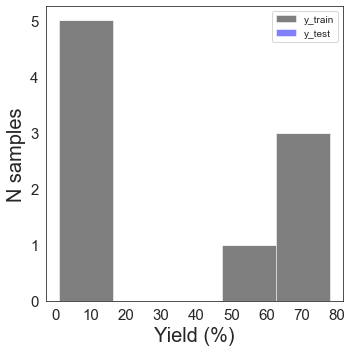

In [9]:
# Split options are 'random', 'ks', 'y_equidistant', 'stratified', 'define', 'none'

# Core options
split = "none"
test_ratio = 0.2 

# Less common parameters
stratified_quantiles = 10 # Number of quantiles to split the data into for stratified sampling
defined_training_set = [] # If you want to manually define the training set, put the list of points here
defined_test_set = [] # If you want to manually define the test set, put the list of points here
randomstate = 42 # Random state for reproducibility

# --------------------------------------------------------------------------------------------------------------
training_set, validation_set, test_set = hotspot_utils.train_test_splits(data_df, split, test_ratio, all_features, RESPONSE_LABEL,
                                                        defined_test_set=defined_test_set, defined_training_set=defined_training_set,
                                                        randomstate=randomstate, stratified_quantiles=stratified_quantiles)

## Automatic Threshold Analysis

In [10]:
# Cutoff in your output for what counts as an active ligand
y_cut = 30

# Set to True if you want points below the y-cut to be considered active
low_is_good = False

# How heavily to value active ligands (1) over inactive ligands (0)
class_weight = {1:1, 0:1} 

# How the prune_hotspots and find_best_hotspots evaluates which are the best
# Can be set to 'accuracy', 'weighted_accuracy', 'f1', and 'weighted_f1'
evaluation_method = 'accuracy'

# How many threshold dimensions do you want?
n_thresholds = 1

# What percentage of thresholds are analyzed in each subsequent step
percentage = 100

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Set up y_class, the binary list of which y values are above y_cut
hotspot_data_df = copy.deepcopy(data_df)
hotspot_data_df['y_class'] = 0

if(low_is_good):
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] < y_cut)
else:
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] > y_cut)

# Find the best thresholds within the full X and y space and make single threshold hotspot objects from them
all_thresholds = hotspot_utils.threshold_generation(hotspot_data_df, class_weight, evaluation_method, all_features)
best_hotspots = []
for thresh in all_thresholds:
    temp_hs = Hotspot(hotspot_data_df, [thresh], y_cut, training_set, test_set, evaluation_method, class_weight)
    best_hotspots.append(temp_hs)

# Cut down to the best {percentage} hotspots
best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)

# Add more thresholds, pruning after each step for resource management
for i in range(n_thresholds - 1):
    with multiprocessing.Pool(processes=int(n_processors-2)) as p:
        new_hotspots = p.starmap(hotspot_utils.hs_next_thresholds_fast, zip(best_hotspots, itertools.repeat(all_thresholds)))
    new_hotspots = [item for sublist in new_hotspots for item in sublist] 
    
    best_hotspots = hotspot_utils.prune_hotspots(new_hotspots, percentage, evaluation_method)

best_hotspots.sort(key = lambda x: x.accuracy_dict[evaluation_method], reverse = True)

# print the top 5 hotspots
for i, hs in enumerate(best_hotspots[:30]):
    print(f'Hotspot Index: {i}')
    print(hs)
    hs.print_stats()
    print('\n**********************************\n')

Hotspot Index: 0
Total accuracy with 1 thresholds: 1.000
Initial accuracy with no thresholds: 0.444
Total accuracy with 1 thresholds: 1.000
Initial accuracy with no thresholds: 0.444
Thresholds: 
	nbo_lp_P_e_boltz > -0.287 with Added accuracy of 0.556

                    all    train    test
         Accuracy: 1.000   1.000   0.000
Weighted Accuracy: 1.000   1.000   0.000
               F1: 1.000   1.000   0.000
      Weighted F1: 1.000   1.000   0.000

        Precision: 1.000
           Recall: 1.000

**********************************

Hotspot Index: 1
Total accuracy with 1 thresholds: 1.000
Initial accuracy with no thresholds: 0.444
Total accuracy with 1 thresholds: 1.000
Initial accuracy with no thresholds: 0.444
Thresholds: 
	pyr_P_boltz < 0.852 with Added accuracy of 0.556

                    all    train    test
         Accuracy: 1.000   1.000   0.000
Weighted Accuracy: 1.000   1.000   0.000
               F1: 1.000   1.000   0.000
      Weighted F1: 1.000   1.000   0.000

 

# Virtual Screening / Validation

## Import Virtual Screening / Validation Parameter Data

This cell must be executed before any other validation or virtual screening cells

In [13]:
# This cell assumes that your spreadsheet is in .xlsx format and that there are no columns after the parameters
# or rows after the last reaction. Extra rows and columns before the data are fine and can be skipped with the
# vs_parameters_header_rows and vs_parameters_start_col variables.

vs_parameters_file = "phosphine_train-val" # Excel file to pull parameters from
vs_parameters_sheet = "validation" # Sheet in the Excel file to pull parameters from
vs_parameters_start_col = 2   # 0-indexed column number where the parameters start
vs_parameters_y_label_col = 0  # 0-indexed column number where the ligand labels are
vs_parameters_header_rows = 0 # Number of rows to skip when reading the parameters. First row should be parameter names.

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Actually start reading stuff into a dataframe
vs_parameters_df = pd.read_excel("./InputData/" + vs_parameters_file + ".xlsx",
                              vs_parameters_sheet,
                              header = vs_parameters_header_rows,
                              index_col = vs_parameters_y_label_col,
                              )

# Skip any columns that are not parameters
vs_parameters_df = vs_parameters_df.iloc[:,vs_parameters_start_col-1:]

# Check that all parameters from the original dataset are present and put them in the same order
try:
  vs_parameters_df = vs_parameters_df[all_features]
except KeyError:
  print('There are features in the main dataset that are not present in this parameter file.')
  print('If your model was built with scaled features, this will cause an error downstream.')

  # If any parameters are missing, at least remove all columns that are not in the original dataset
  columns_to_keep = [col for col in vs_parameters_df.columns if col in all_features]
  vs_parameters_df = vs_parameters_df[columns_to_keep]

# Display the dataframe
display(vs_parameters_df)

,nbo_lp_P_e_boltz,pyr_P_boltz,vbur_vbur_min
ID,,,
60,-0.259440,0.755765,86.647971
91,-0.286998,0.848931,67.372994
281,-0.288775,0.868400,65.826101
291,-0.273551,0.767299,78.110251
306,-0.279132,0.857095,66.921163
349,-0.279091,0.859695,65.849111
371,-0.282973,0.859586,66.277932
527,-0.278916,0.860523,65.751842
534,-0.275946,0.775464,77.885382


## Validation

In [14]:
# Run this cell before the specific validation cells to set up the validation dataframe
# Read the validation results from the excel sheet
# The final result should be a dataframe with indicies corresponding to the vs_parameters_df from above,
# a column of experimental outputs, and all the relevant parameters

validation_file = "phosphine_train-val" # Excel file to pull validation results from
validation_sheet = "validation" # Sheet in the Excel file to pull validation results from
validation_response_col = 1 # 0-indexed column number for the experimental output
validation_y_label_col = 0  # 0-indexed column number where the ligand labels are
validation_header_rows = 0 # Number of rows to skip when reading the responses

############################################################################################################

vs_response_df = pd.read_excel('./InputData/' + validation_file + '.xlsx',
                              sheet_name=validation_sheet,
                              header=validation_header_rows,
                              index_col=validation_y_label_col
                              )

# Drop all columns except the experimental output
vs_response_df = vs_response_df.iloc[:, [validation_response_col-1]]
vs_response_df.columns = [RESPONSE_LABEL]

for column in vs_response_df.columns:
    vs_response_df[column] = pd.to_numeric(vs_response_df[column], errors='coerce')
vs_response_df.dropna(inplace = True)

vs_combined_df = pd.concat([vs_response_df, vs_parameters_df], axis=1, join='inner')

display(vs_combined_df)

,Yield (%),nbo_lp_P_e_boltz,pyr_P_boltz,vbur_vbur_min
ID,,,,
60,0,-0.259440,0.755765,86.647971
91,0,-0.286998,0.848931,67.372994
281,0,-0.288775,0.868400,65.826101
291,72,-0.273551,0.767299,78.110251
306,1,-0.279132,0.857095,66.921163
349,0,-0.279091,0.859695,65.849111
371,77,-0.282973,0.859586,66.277932
527,22,-0.278916,0.860523,65.751842
534,61,-0.275946,0.775464,77.885382


### Threshold Validation

Accuracy: 0.56
Precision: 0.43
Recall: 1.00


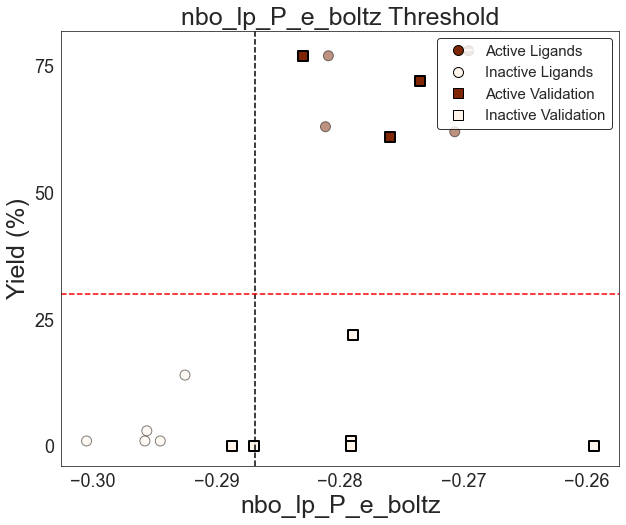

,nbo_lp_P_e_boltz
ID,
60,True
91,False
281,False
291,True
306,True
349,True
371,True
527,True
534,True


In [15]:
# Select hotspot to validate
hotspot_index = 0

# Set to True if you want to see only the virtual screen results plotted
hide_training = False

save_evaluation = False # Set to True if you want to save the threshold evaluation to an Excel file in the OutputData folder
save_filename = "threshold_evaluation" # Name of the Excel file to save the threshold evaluation to if save_evaluation is True

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE PLOTTING DETAILS IN hotspot_utils.plot_hotspot(...)
# --------------------------------------------------------------------------------------------------------------

hs = best_hotspots[hotspot_index]

# Evaluate each validation point on each threshold
threshold_evaluations = hs.expand(vs_combined_df)

# Get validation stats and display the hotspot
hs.get_external_accuracy(vs_combined_df, RESPONSE_LABEL, verbose=True)
hotspot_utils.plot_hotspot(hs, vs_combined_df, vs_parameters_df, coloring='binary', output_label=RESPONSE_LABEL, hide_training=hide_training)

# Display the threshold evaluations
# True means the point is in on the active side of that threshold
display(threshold_evaluations)

# Save the threshold evaluations to an Excel file if requested
if save_evaluation:
    threshold_evaluations.to_excel("./OutputData/" + save_filename + ".xlsx")

Accuracy: 0.67
Precision: 0.50
Recall: 0.67


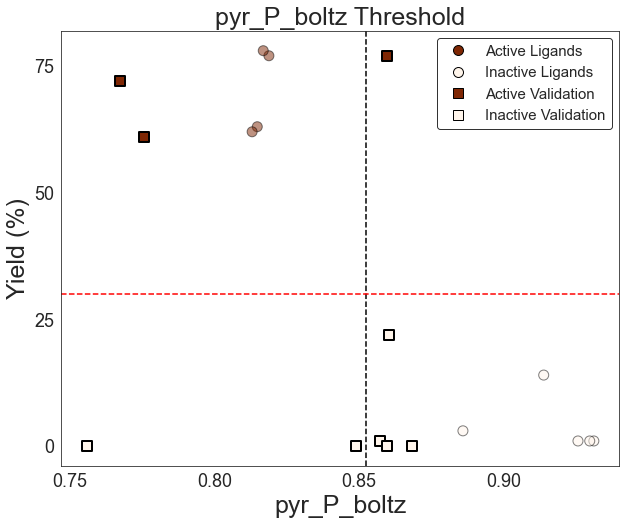

,pyr_P_boltz
ID,
60,True
91,True
281,False
291,True
306,False
349,False
371,False
527,False
534,True


In [19]:
# Select hotspot to validate
hotspot_index = 1

# Set to True if you want to see only the virtual screen results plotted
hide_training = False

save_evaluation = False # Set to True if you want to save the threshold evaluation to an Excel file in the OutputData folder
save_filename = "threshold_evaluation" # Name of the Excel file to save the threshold evaluation to if save_evaluation is True

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE PLOTTING DETAILS IN hotspot_utils.plot_hotspot(...)
# --------------------------------------------------------------------------------------------------------------

hs = best_hotspots[hotspot_index]

# Evaluate each validation point on each threshold
threshold_evaluations = hs.expand(vs_combined_df)

# Get validation stats and display the hotspot
hs.get_external_accuracy(vs_combined_df, RESPONSE_LABEL, verbose=True)
hotspot_utils.plot_hotspot(hs, vs_combined_df, vs_parameters_df, coloring='binary', output_label=RESPONSE_LABEL, hide_training=hide_training)

# Display the threshold evaluations
# True means the point is in on the active side of that threshold
display(threshold_evaluations)

# Save the threshold evaluations to an Excel file if requested
if save_evaluation:
    threshold_evaluations.to_excel("./OutputData/" + save_filename + ".xlsx")

Accuracy: 0.78
Precision: 0.67
Recall: 0.67


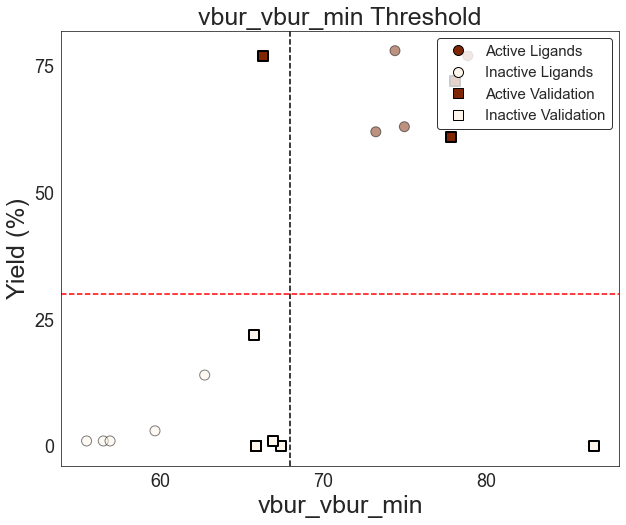

,vbur_vbur_min
ID,
60,True
91,False
281,False
291,True
306,False
349,False
371,False
527,False
534,True


In [17]:
# Select hotspot to validate
hotspot_index = 2

# Set to True if you want to see only the virtual screen results plotted
hide_training = False

save_evaluation = False # Set to True if you want to save the threshold evaluation to an Excel file in the OutputData folder
save_filename = "threshold_evaluation" # Name of the Excel file to save the threshold evaluation to if save_evaluation is True

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE PLOTTING DETAILS IN hotspot_utils.plot_hotspot(...)
# --------------------------------------------------------------------------------------------------------------

hs = best_hotspots[hotspot_index]

# Evaluate each validation point on each threshold
threshold_evaluations = hs.expand(vs_combined_df)

# Get validation stats and display the hotspot
hs.get_external_accuracy(vs_combined_df, RESPONSE_LABEL, verbose=True)
hotspot_utils.plot_hotspot(hs, vs_combined_df, vs_parameters_df, coloring='binary', output_label=RESPONSE_LABEL, hide_training=hide_training)

# Display the threshold evaluations
# True means the point is in on the active side of that threshold
display(threshold_evaluations)

# Save the threshold evaluations to an Excel file if requested
if save_evaluation:
    threshold_evaluations.to_excel("./OutputData/" + save_filename + ".xlsx")